<h1>CNN modeli za prepoznavanje šalica</h1>
<hr/>
<h2>Model Golf</h2>

<p> Set slika je 700/100, Dropot-a i Data Augmentation i regularizacija</p>
<p>dodano sjeme</p>

In [36]:
import os
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, SpatialDropout2D

import matplotlib.pyplot as plt
import numpy as np

<h4>POstavljanje sjemena za ponavljanje rezultata:</h4>

In [44]:
seed = 77
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

<p>Postavljanje direktorija sa trening i validacijskim slikama:</p>

In [29]:
# Postavi direktorije slika
train_dir = "../../Projekt_slike_128/Trening"
test_dir = "../../Projekt_slike_128/Validacija"

<h3> Funkcija za određivanje broja epoha, veličinu batcheva i generiranje podataka</h3>

In [30]:
def generate_epochs_batchs_data():
    """ određivanje i priprema podataka """
    # Odredi broj epoha i veličinu batcheva
    num_of_epochs = input("Number of epochs:")
    num_of_epochs = int(num_of_epochs)
    size_of_batch = input("Batch size:")
    size_of_batch = int(size_of_batch)
    # Generator podataka sa augmentacijom za trening
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=(128, 128), batch_size=size_of_batch, class_mode="categorical"
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=(128, 128), batch_size=size_of_batch, class_mode="categorical"
    )
    return(train_generator,test_generator, num_of_epochs, size_of_batch)

In [31]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 2
Batch size: 128


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


<h3>Funkcija za plotanje rezultata </h3>

In [32]:
def plots_and_evaluation(history):
    """ funkcija za plotanje točnosti i gubitka  """
    # Plot trening i valuacija - točnost
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    # Plot trening i validacija - gubitak
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


<p>Prikaz random primjera slika:</p>

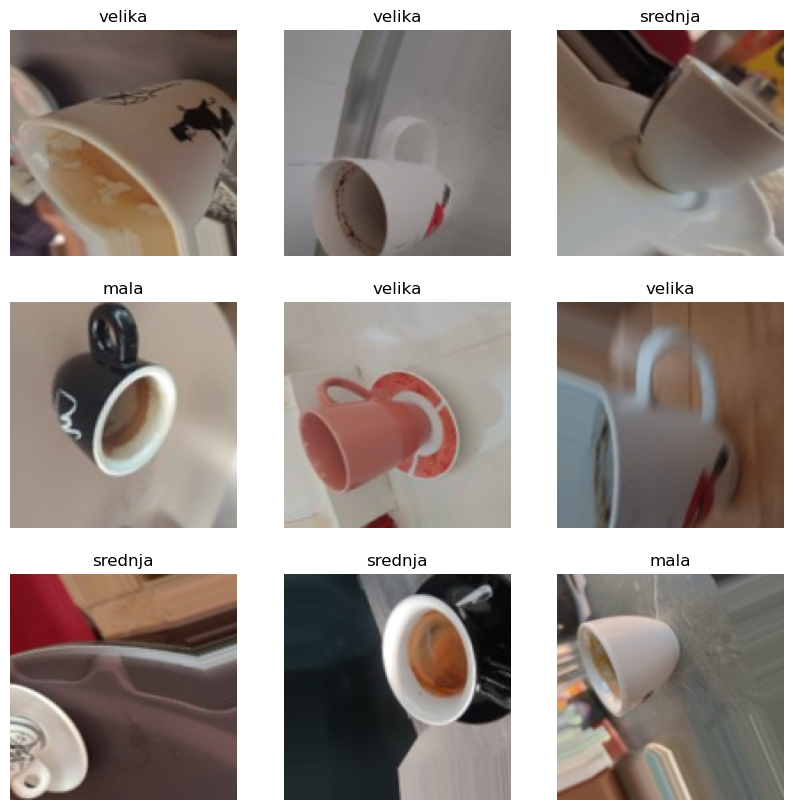

In [33]:
# Primjeri slika
def display_sample_images(generator):
    x, y = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[i])
        
        if (np.argmax(y[i])==0):
            plt.title("mala")
        if (np.argmax(y[i])==1):
            plt.title("srednja")
        if (np.argmax(y[i])==2):
            plt.title("velika")
        plt.axis("off")
    plt.show()


display_sample_images(train_generator)

<h2> Model G.1</h2>
<p>ponavljanje Echo modela</p>
<p> batch 128, epochs 100, parametri 3 000 000</p>
<p>najbolji model iz Echo - Dropout mijenjan za SPatialDropout2D</p>

In [34]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 100
Batch size: 128


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [37]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(16, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(32, (3, 3), activation="relu"),
        SpatialDropout2D(0.5),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 63, 63, 8)         0         
 ng2D)                                                           
                                                                 
 spatial_dropout2d (Spatial  (None, 63, 63, 8)         0         
 Dropout2D)                                                      
                                                                 
 conv2d_17 (Conv2D)          (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                      

In [38]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/100


2024-08-19 13:32:34.870282: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16/16 [==============================] - 32s 2s/step - loss: 1.2407 - accuracy: 0.3448 - val_loss: 1.0965 - val_accuracy: 0.3477
Epoch 2/100
16/16 [==============================] - 28s 2s/step - loss: 1.1054 - accuracy: 0.3403 - val_loss: 1.0978 - val_accuracy: 0.3867
Epoch 3/100
16/16 [==============================] - 27s 2s/step - loss: 1.0983 - accuracy: 0.3712 - val_loss: 1.0964 - val_accuracy: 0.4297
Epoch 4/100
16/16 [==============================] - 27s 2s/step - loss: 1.0945 - accuracy: 0.3955 - val_loss: 1.0953 - val_accuracy: 0.3945
Epoch 5/100
16/16 [==============================] - 27s 2s/step - loss: 1.0945 - accuracy: 0.3717 - val_loss: 1.0930 - val_accuracy: 0.3477
Epoch 6/100
16/16 [==============================] - 27s 2s/step - loss: 1.0890 - accuracy: 0.3900 - val_loss: 1.0822 - val_accuracy: 0.5586
Epoch 7/100
16/16 [==============================] - 27s 2s/step - loss: 1.0823 - accuracy: 0.3895 - val_loss: 1.0888 - val_accuracy: 0.3438
Epoch 8/100
16/16 [======

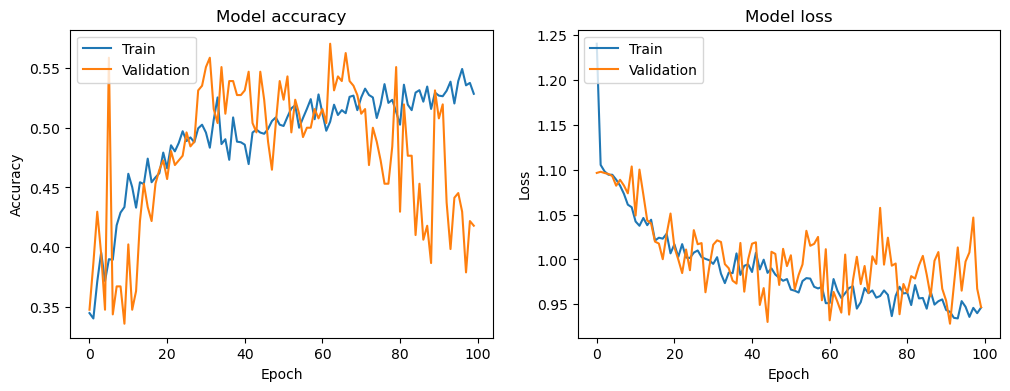

2/2 [==============================] - 1s 243ms/step - loss: 0.9396 - accuracy: 0.4219
Test accuracy: 0.421875


In [39]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2> Model G.2</h2>
<p>dodana L2 regularizacija </p>
<p> batch 128, epochs 100, parametri 3 000 000</p>
<p>najbolji model iz Echo</p>

In [40]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 100
Batch size: 128


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [41]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Conv2D(16, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Conv2D(32, (3, 3), activation="relu" , kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 63, 63, 8)         0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 63, 63, 8)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 30, 30, 16)       

In [42]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/100


2024-08-19 14:22:53.459966: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16/16 [==============================] - 32s 2s/step - loss: 1.7055 - accuracy: 0.3423 - val_loss: 1.1288 - val_accuracy: 0.4258
Epoch 2/100
16/16 [==============================] - 27s 2s/step - loss: 1.1372 - accuracy: 0.3387 - val_loss: 1.1288 - val_accuracy: 0.3359
Epoch 3/100
16/16 [==============================] - 27s 2s/step - loss: 1.1260 - accuracy: 0.3585 - val_loss: 1.1289 - val_accuracy: 0.3359
Epoch 4/100
16/16 [==============================] - 27s 2s/step - loss: 1.1228 - accuracy: 0.3636 - val_loss: 1.1301 - val_accuracy: 0.3438
Epoch 5/100
16/16 [==============================] - 27s 2s/step - loss: 1.1156 - accuracy: 0.3722 - val_loss: 1.1343 - val_accuracy: 0.3203
Epoch 6/100
16/16 [==============================] - 27s 2s/step - loss: 1.0971 - accuracy: 0.3920 - val_loss: 1.1494 - val_accuracy: 0.3438
Epoch 7/100
16/16 [==============================] - 27s 2s/step - loss: 1.0893 - accuracy: 0.4209 - val_loss: 1.1604 - val_accuracy: 0.3516
Epoch 8/100
16/16 [======

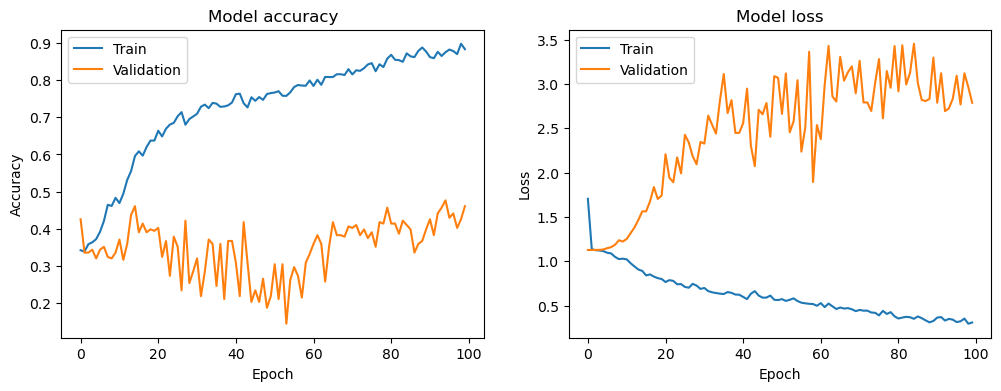

2/2 [==============================] - 1s 236ms/step - loss: 2.8593 - accuracy: 0.4648
Test accuracy: 0.46484375


In [43]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2> Model G.3</h2>
<p>dodana L2 regularizacija na dva mjesta </p>
<p> batch 128, epochs 100, parametri 3 000 000</p>
<p>najbolji model iz Echo</p>

In [45]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 100
Batch size: 128


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [46]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(16, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(32, (3, 3), activation="relu",  kernel_regularizer=l2(0.001)),
        SpatialDropout2D(0.5),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 63, 63, 8)         0         
 ng2D)                                                           
                                                                 
 spatial_dropout2d_4 (Spati  (None, 63, 63, 8)         0         
 alDropout2D)                                                    
                                                                 
 conv2d_23 (Conv2D)          (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                      

In [47]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/100


2024-08-19 15:28:45.508363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/spatial_dropout2d_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16/16 [==============================] - 32s 2s/step - loss: 1.2584 - accuracy: 0.3377 - val_loss: 1.1279 - val_accuracy: 0.3008
Epoch 2/100
16/16 [==============================] - 28s 2s/step - loss: 1.1391 - accuracy: 0.3564 - val_loss: 1.1254 - val_accuracy: 0.5312
Epoch 3/100
16/16 [==============================] - 27s 2s/step - loss: 1.1233 - accuracy: 0.3712 - val_loss: 1.1212 - val_accuracy: 0.6484
Epoch 4/100
16/16 [==============================] - 27s 2s/step - loss: 1.1278 - accuracy: 0.3788 - val_loss: 1.1203 - val_accuracy: 0.4727
Epoch 5/100
16/16 [==============================] - 27s 2s/step - loss: 1.1172 - accuracy: 0.3955 - val_loss: 1.1171 - val_accuracy: 0.4609
Epoch 6/100
16/16 [==============================] - 27s 2s/step - loss: 1.1147 - accuracy: 0.3874 - val_loss: 1.1070 - val_accuracy: 0.5156
Epoch 7/100
16/16 [==============================] - 27s 2s/step - loss: 1.1065 - accuracy: 0.4016 - val_loss: 1.0996 - val_accuracy: 0.5039
Epoch 8/100
16/16 [======

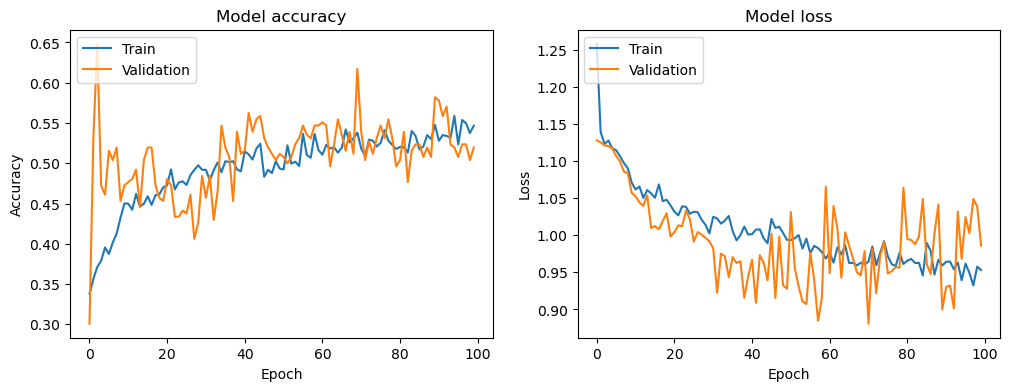

2/2 [==============================] - 1s 239ms/step - loss: 0.9987 - accuracy: 0.5078
Test accuracy: 0.5078125


In [48]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2> Model G.4</h2>
<p>dodana L2 regularizacija na dva mjesta </p>
<p> batch 128, epochs 100, parametri 3 000 000</p>
<p>SpatialDropuot2D smanjen na 0.4</p>
<p>najbolji model iz Echo</p>

In [49]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 100
Batch size: 128


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [50]:
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.4),
        Conv2D(16, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.4),
        Conv2D(32, (3, 3), activation="relu",  kernel_regularizer=l2(0.001)),
        SpatialDropout2D(0.4),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.4),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 63, 63, 8)         0         
 ng2D)                                                           
                                                                 
 spatial_dropout2d_8 (Spati  (None, 63, 63, 8)         0         
 alDropout2D)                                                    
                                                                 
 conv2d_26 (Conv2D)          (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                      

In [51]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/100


2024-08-19 16:24:56.549196: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/spatial_dropout2d_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16/16 [==============================] - 32s 2s/step - loss: 1.2019 - accuracy: 0.3382 - val_loss: 1.1278 - val_accuracy: 0.3555
Epoch 2/100
16/16 [==============================] - 27s 2s/step - loss: 1.1251 - accuracy: 0.3555 - val_loss: 1.1239 - val_accuracy: 0.3984
Epoch 3/100
16/16 [==============================] - 27s 2s/step - loss: 1.1214 - accuracy: 0.3479 - val_loss: 1.1198 - val_accuracy: 0.4883
Epoch 4/100
16/16 [==============================] - 27s 2s/step - loss: 1.1056 - accuracy: 0.3900 - val_loss: 1.1106 - val_accuracy: 0.3984
Epoch 5/100
16/16 [==============================] - 27s 2s/step - loss: 1.1014 - accuracy: 0.3991 - val_loss: 1.1049 - val_accuracy: 0.4297
Epoch 6/100
16/16 [==============================] - 27s 2s/step - loss: 1.0859 - accuracy: 0.4366 - val_loss: 1.0911 - val_accuracy: 0.3750
Epoch 7/100
16/16 [==============================] - 27s 2s/step - loss: 1.0698 - accuracy: 0.4442 - val_loss: 1.0780 - val_accuracy: 0.3711
Epoch 8/100
16/16 [======

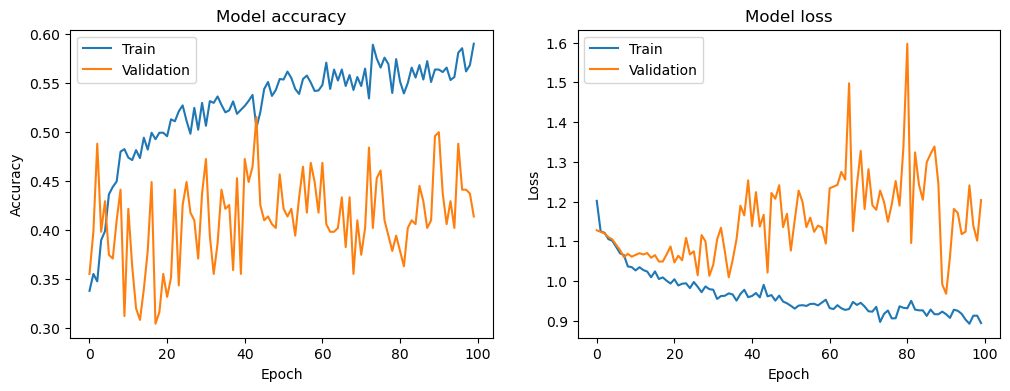

2/2 [==============================] - 1s 293ms/step - loss: 1.1912 - accuracy: 0.4102
Test accuracy: 0.41015625


In [52]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2> Model G.5</h2>
<p>dodana L2 regularizacija na dva mjesta </p>
<p> batch 128, epochs 200, parametri 3 000 000</p>
<p>SpatialDropuot2D vraćen na 0.5</p>
<p>najbolji model iz Echo</p>

In [53]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 200
Batch size: 128


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [55]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(16, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(32, (3, 3), activation="relu",  kernel_regularizer=l2(0.001)),
        SpatialDropout2D(0.5),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 63, 63, 8)         0         
 ng2D)                                                           
                                                                 
 spatial_dropout2d_12 (Spat  (None, 63, 63, 8)         0         
 ialDropout2D)                                                   
                                                                 
 conv2d_29 (Conv2D)          (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                      

In [56]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/200


2024-08-19 17:17:44.081553: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/spatial_dropout2d_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16/16 [==============================] - 32s 2s/step - loss: 1.2317 - accuracy: 0.3534 - val_loss: 1.1276 - val_accuracy: 0.3320
Epoch 2/200
16/16 [==============================] - 27s 2s/step - loss: 1.1332 - accuracy: 0.3357 - val_loss: 1.1248 - val_accuracy: 0.3711
Epoch 3/200
16/16 [==============================] - 27s 2s/step - loss: 1.1220 - accuracy: 0.3519 - val_loss: 1.1233 - val_accuracy: 0.4258
Epoch 4/200
16/16 [==============================] - 27s 2s/step - loss: 1.1227 - accuracy: 0.3707 - val_loss: 1.1213 - val_accuracy: 0.3750
Epoch 5/200
16/16 [==============================] - 27s 2s/step - loss: 1.1214 - accuracy: 0.3565 - val_loss: 1.1191 - val_accuracy: 0.3789
Epoch 6/200
16/16 [==============================] - 27s 2s/step - loss: 1.1125 - accuracy: 0.3930 - val_loss: 1.1165 - val_accuracy: 0.3789
Epoch 7/200
16/16 [==============================] - 27s 2s/step - loss: 1.1109 - accuracy: 0.3930 - val_loss: 1.1065 - val_accuracy: 0.4805
Epoch 8/200
16/16 [======

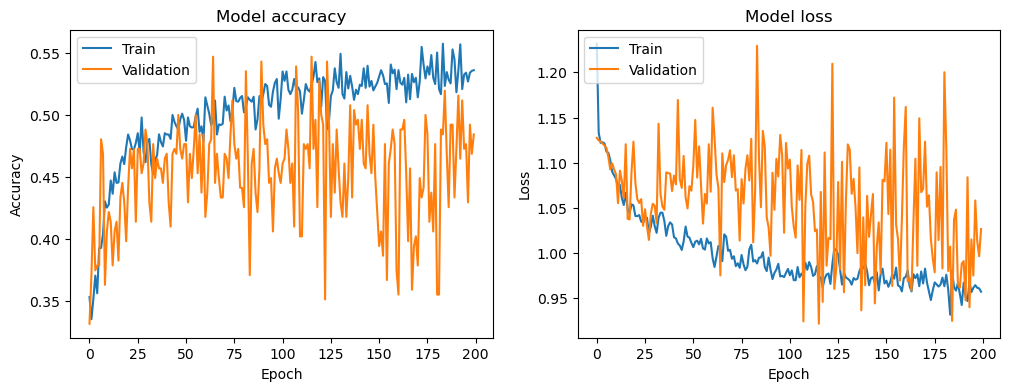

2/2 [==============================] - 1s 228ms/step - loss: 1.0394 - accuracy: 0.4766
Test accuracy: 0.4765625


In [57]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h5>Zaključak:</h5>
<p>Korištenje SpatialDropout2D približio je vrijenosti treninga i validacije</p>
<p>smanjivanje Dropouta na 0.4 pogoršalo je rezultate</p>
<p> podizanje na 200 epoha nije donijelo poboljšanje: </p>
<p>točnost treninga ostane na oko 54%</p>
<p>U najboljoj verziji točnost validacije je 50% , a gubitak 1.00</p>